In [218]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


In [219]:
%cd C:\Users\Michel\DataspellProjects\dsProject\multivariate_tsa

C:\Users\Michel\DataspellProjects\dsProject\multivariate_tsa


In [220]:
df_train = pd.read_csv('datatrain.csv')
df_train.head()

,ytrain,ptrain,f1train,f2train,f3train,f4train,f5train
0,0.673637,1074.969347,1140.697803,861.479758,1073.522570,2082.532820,1291.340172
1,0.058719,1075.594908,1140.743576,861.845194,1073.841938,2082.842577,1291.484252
2,0.381526,1075.341261,1141.177709,862.084960,1073.930892,2083.098220,1291.687519
3,0.528869,1075.289785,1141.062180,862.336933,1074.061455,2083.308693,1291.672426
4,1.024721,1074.979684,1141.300213,862.278979,1074.477235,2082.966599,1292.210891


In [221]:
df_test = pd.read_csv('datatest.csv')
df_test.head()

,ytest,ptest,f1test,f2test,f3test,f4test,f5test
0,1.381905,1076.864590,1140.854346,861.419805,1073.114623,2082.098773,1291.935605
1,1.273603,1077.203757,1140.903094,861.955296,1073.535015,2082.406655,1292.018294
2,1.397008,1077.333586,1141.665126,861.636839,1073.798821,2082.491491,1291.985945
3,1.787893,1077.266791,1141.220056,862.236499,1073.295732,2082.351245,1292.492481
4,2.151199,1077.293432,1141.144072,861.613974,1073.663142,2082.951864,1292.025839


#Графики и корреляция 

In [222]:
def series_plot(df):  
  fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
  df = df.iloc[: , 1:]

  for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]

    if df.columns[i]=='ptest' or df.columns[i]=='ptrain':  
      ax.plot(data, color='green', linewidth=1)
      ax.set_title(df.columns[i])

    else:
      ax.plot(data, color='red', linewidth=1)
      ax.set_title(df.columns[i])
      
    ax.grid()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

  plt.tight_layout();

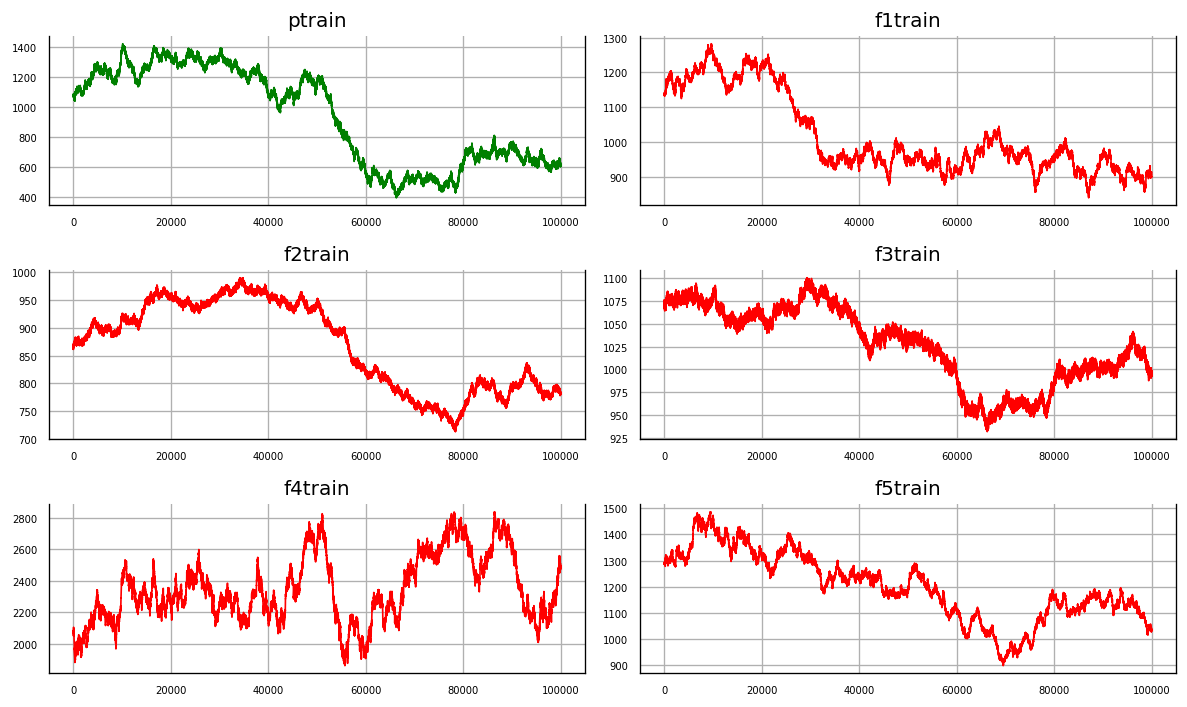

In [223]:
series_plot(df_train)

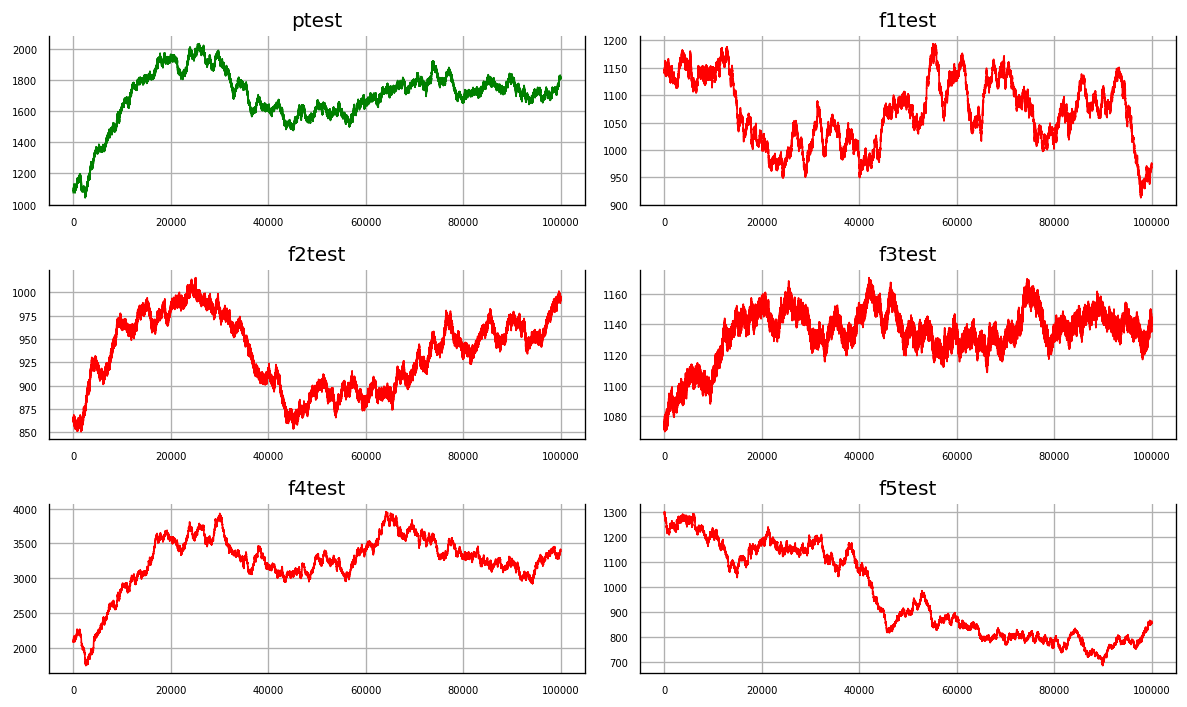

In [224]:
series_plot(df_test)

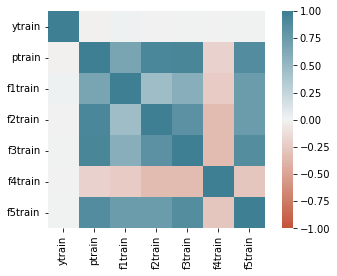

In [225]:
corr = df_train.corr()

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

#Данные

In [226]:
def data_with_lags(data, sec, lag, use_y):
  for i in range(1,lag):
    data[str(data.columns[1])+str(i)+'lag'] = data[str(data.columns[1])].shift(i)

  for i in range(2,7):
    for j in range(1,lag):
      data[str(data.columns[i])+str(j)+'lag'] = data[str(data.columns[i])].shift(j)

  if use_y:
    for i in range(1,sec):
      data[str(str(data.columns[0])+str(i)+'lag')] = data[str(data.columns[0])].shift(sec-1+i)
      
  return data

In [227]:
n_sec = n_lag = 6

df_train = data_with_lags(df_train,n_sec,n_lag,True).iloc[max(n_lag,n_sec+5):,:]
df_test = data_with_lags(df_test,n_sec,n_lag,True).iloc[max(n_lag,n_sec+5):,:]

In [228]:
df_test.head(10)

,ytest,ptest,f1test,f2test,f3test,f4test,f5test,ptest1lag,ptest2lag,ptest3lag,...,f5test1lag,f5test2lag,f5test3lag,f5test4lag,f5test5lag,ytest1lag,ytest2lag,ytest3lag,ytest4lag,ytest5lag
11,7.127563,1077.190765,1141.481694,864.998459,1072.990597,2084.042242,1293.558788,1084.536292,1077.120222,1077.358419,...,1292.551784,1291.980523,1292.762574,1292.659474,1292.306838,2.512000,2.151199,1.787893,1.397008,1.273603
12,3.418172,1081.519767,1143.127205,864.632203,1073.840176,2088.541913,1295.267800,1077.190765,1084.536292,1077.120222,...,1293.558788,1292.551784,1291.980523,1292.762574,1292.659474,3.337174,2.512000,2.151199,1.787893,1.397008
13,0.655764,1084.401044,1143.012256,865.276387,1072.200774,2091.929531,1299.467705,1081.519767,1077.190765,1084.536292,...,1295.267800,1293.558788,1292.551784,1291.980523,1292.762574,4.418535,3.337174,2.512000,2.151199,1.787893
14,-0.461490,1085.434644,1142.427596,863.929642,1072.567133,2096.602140,1299.393259,1084.401044,1081.519767,1077.190765,...,1299.467705,1295.267800,1293.558788,1292.551784,1291.980523,4.821403,4.418535,3.337174,2.512000,2.151199
15,-2.015498,1086.623304,1141.837109,865.436936,1073.332460,2095.163460,1300.142647,1085.434644,1084.401044,1081.519767,...,1299.393259,1299.467705,1295.267800,1293.558788,1292.551784,6.179811,4.821403,4.418535,3.337174,2.512000
16,2.688995,1082.406244,1141.952082,864.220580,1071.226426,2094.216608,1300.657888,1086.623304,1085.434644,1084.401044,...,1300.142647,1299.393259,1299.467705,1295.267800,1293.558788,-1.509971,6.179811,4.821403,4.418535,3.337174
17,1.289036,1084.039865,1143.636676,864.290441,1073.174627,2091.631748,1301.267295,1082.406244,1086.623304,1085.434644,...,1300.657888,1300.142647,1299.393259,1299.467705,1295.267800,7.127563,-1.509971,6.179811,4.821403,4.418535
18,-5.780174,1090.061307,1145.099386,862.013230,1073.314674,2089.236818,1299.601978,1084.039865,1082.406244,1086.623304,...,1301.267295,1300.657888,1300.142647,1299.393259,1299.467705,3.418172,7.127563,-1.509971,6.179811,4.821403
19,6.706550,1078.790274,1146.011103,861.978788,1071.297814,2086.891822,1298.736322,1090.061307,1084.039865,1082.406244,...,1299.601978,1301.267295,1300.657888,1300.142647,1299.393259,0.655764,3.418172,7.127563,-1.509971,6.179811
20,7.451923,1079.395706,1146.052370,862.806916,1072.259495,2082.998659,1296.545023,1078.790274,1090.061307,1084.039865,...,1298.736322,1299.601978,1301.267295,1300.657888,1300.142647,-0.461490,0.655764,3.418172,7.127563,-1.509971


In [229]:
X_train = df_train.iloc[:int(df_train.shape[0]*0.8),1:]
Y_train = df_train.iloc[:int(df_train.shape[0]*0.8),:1]

X_val = df_train.iloc[int(df_train.shape[0]*0.8):,1:]
Y_val = df_train.iloc[int(df_train.shape[0]*0.8):,:1]

X_test = df_test.iloc[:,1:]
Y_test = df_test.iloc[:,:1]

#Модель и метрики 

In [230]:
def print_metrics(predict, target):
  target = [lst[0] for lst in list(target.values)]
  pred = [lst[0] for lst in predict]

  pearson = pearsonr(target, pred)[0]
  r2 = r2_score(target, pred)
  spearman = spearmanr(target, pred)[0]
  mean_abs = mae(target, pred)

  return "Pearsonr: {}, Spearmanr: {}, R2: {}, MAE: {}".format(pearson,
                                                               spearman,
                                                               r2,
                                                               mean_abs) 


In [173]:
regressor = RidgeCV()
regressor.fit(X_train, Y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [175]:
regressor.coef_

array([[-5.78027663e-01,  5.33491447e-01,  5.90152831e-01,
         4.80695634e-01,  5.92553463e-01,  5.33803716e-02,
         2.10973451e-01,  1.38449630e-01,  1.42167735e-01,
         6.36811689e-02, -6.21495497e-02, -5.28937297e-01,
         1.73761138e-01,  5.30079044e-02,  1.17736890e-01,
        -3.01345423e-01, -2.72208998e-01, -3.17363360e-01,
         9.72747024e-02,  6.54994721e-02,  1.42291169e-02,
        -1.00580980e-01,  2.47935030e-01, -2.36013101e-01,
        -4.16841737e-02, -7.21205207e-02, -8.09527628e-01,
         4.47064503e-01, -8.65623772e-03, -5.41973368e-01,
         3.44270211e-01, -5.11852577e-02,  1.53137720e-02,
         2.96678236e-03, -5.24949343e-04, -1.63295632e-02]])

In [174]:
pred_train = regressor.predict(X_train)
print_metrics(pred_train, Y_train)

'Pearsonr: 0.7753752452620198, Spearmanr: 0.759879294718522, R2: 0.6012067701638355, MAE: 2.299696310732125'

In [176]:
pred_val = regressor.predict(X_val)
print_metrics(pred_val, Y_val)

'Pearsonr: 0.7720003265696521, Spearmanr: 0.7556312617289757, R2: 0.5864925698532877, MAE: 2.331198031283643'

In [177]:
pred_test = regressor.predict(X_test)
print_metrics(pred_test, Y_test)

'Pearsonr: 0.7543570012453295, Spearmanr: 0.7384319260180527, R2: 0.5356583366051304, MAE: 2.479102905421223'

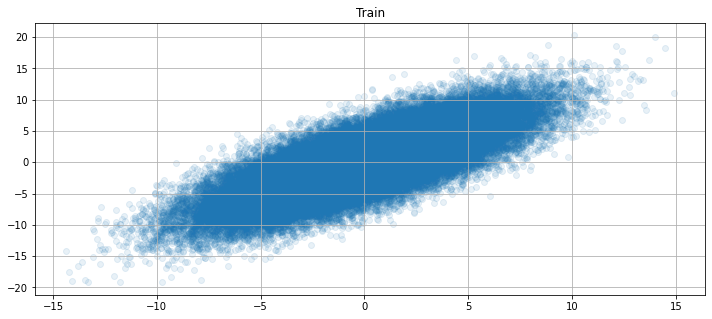

In [178]:
plt.figure(figsize=(12,5))
plt.scatter(pred_train,Y_train,alpha=0.1)
plt.grid()
plt.title('Train')
plt.show()

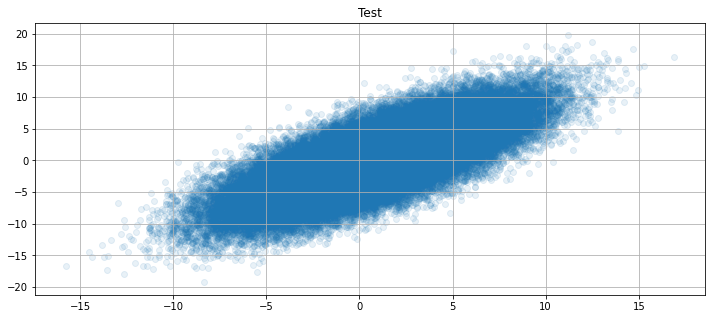

In [179]:
plt.figure(figsize=(12,5))
plt.scatter(pred_test,Y_test,alpha=0.1)
plt.grid()
plt.title('Test')
plt.show()

#Использование прошлых значений y в качестве тренировочных для предсказания y в настоящий момент времени 

In [231]:
regressor = RidgeCV()
regressor.fit(X_train,Y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [232]:
pred_train = regressor.predict(X_train)
print_metrics(pred_train, Y_train)

'Pearsonr: 0.8078559484130861, Spearmanr: 0.7939580977003469, R2: 0.652631232611373, MAE: 2.146905575584465'

In [233]:
pred_val = regressor.predict(X_val)
print_metrics(pred_val, Y_val)

'Pearsonr: 0.8109652865834421, Spearmanr: 0.7978314040016852, R2: 0.6567559527218225, MAE: 2.1166495373895'

In [234]:
pred_test = regressor.predict(X_test)
print_metrics(pred_test, Y_test)

'Pearsonr: 0.8080949259749117, Spearmanr: 0.7944638615444904, R2: 0.6529044555447117, MAE: 2.1401038550916986'

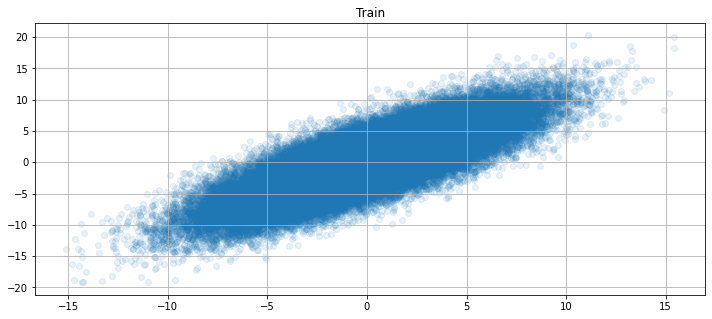

In [235]:
plt.figure(figsize=(12,5))
plt.scatter(pred_train,Y_train,alpha=0.1)
plt.grid()
plt.title('Train')
plt.show()

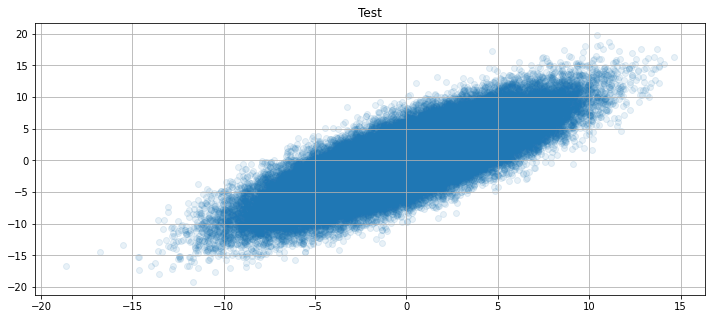

In [236]:
plt.figure(figsize=(12,5))
plt.scatter(pred_test,Y_test,alpha=0.1)
plt.grid()
plt.title('Test')
plt.show()